# 02 · S3WD v02 主线：参考元组 + 相似度 + 漂移闭环

本 Notebook 演示 S3WD v02 流程：利用 Reference Tuple（参考元组）/混合相似度/批级阈值小网格，结合漂移分级响应（S1/S2/S3）。
运行前请确认 `configs/s3wd_airline_v02.yaml` 已更新至 v02 键位，并准备好 Airlines 数据。


In [2]:
import os
from pathlib import Path
import sys
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 's3wdlib').exists() and (PROJECT_ROOT.parent / 's3wdlib').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

print("【步骤0】环境信息：", {
    'python': sys.version.split()[0],
    'cwd': os.getcwd(),
    'project_root': str(PROJECT_ROOT)
})



【步骤0】环境信息： {'python': '3.11.5', 'cwd': 'e:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验\\notebooks', 'project_root': 'e:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验'}


In [3]:
from s3wdlib.config_loader import load_yaml_cfg, extract_vars, show_cfg
from s3wdlib import (
    augment_airline_features,
    assign_year_from_month_sequence,
    run_streaming_flow,
    assign_buckets,
    build_ref_tuples,
    combine_history,
    corr_to_set,
    to_trisect_probs,
    expected_cost,
    expected_fbeta,
    select_alpha_beta,
    ema_clip,
    detect_drift,
    apply_actions,
    compute_region_masks,
)
import s3wdlib.bucketizer as bucketizer
import s3wdlib.similarity as similarity
import s3wdlib.drift_controller as drift_controller
from s3wdlib.gwb import GWBProbEstimator

CONFIG_PATH = Path('../configs/s3wd_airline_v02.yaml')
cfg = load_yaml_cfg(str(CONFIG_PATH))
show_cfg(cfg)
vars_flat = extract_vars(cfg)

bucketizer.configure(cfg.get('BUCKET'))
similarity.configure(cfg.get('SIMILARITY'))

sim_cfg = similarity.current_config()
drift_thresholds = {
    'psi_thresholds': cfg['DRIFT'].get('psi_thresholds'),
    'tv_thresholds': cfg['DRIFT'].get('tv_thresholds'),
    'posrate_shift': cfg['DRIFT'].get('posrate_shift'),
    'perf_drop': cfg['DRIFT'].get('perf_drop'),
    'debounce_windows': cfg['DRIFT'].get('debounce_windows', 1),
}
actions_cfg = cfg['DRIFT'].get('actions', {})


[INFO] Loading faiss.
[INFO] Successfully loaded faiss.


【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42, 'start_year': 1987}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 10, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.72, 'bandwidth_scale': 1.05, 'use_faiss': True, 'faiss_gpu': True, 'categorical_features': ['Origin', 'Dest'], 'category_penalty': 0.3}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- BUCKET: {'keys': ['UniqueCarrier', 'Origin', 'Dest', 'dep_hour'], 'min_bucket': 

In [4]:
from s3wdlib.data_io import load_table_auto, assign_year_from_month_sequence

data_dir = Path(cfg['DATA']['data_dir'])
data_path = data_dir / cfg['DATA']['data_file']
start_year_cfg = cfg['DATA'].get('start_year')
if start_year_cfg is None:
    raise KeyError('配置缺少 DATA.start_year，用于生成年份窗口。')
start_year_cfg = int(start_year_cfg)

X_raw, y = load_table_auto(
    str(data_path),
    continuous_label=cfg['DATA'].get('continuous_label'),
    threshold=cfg['DATA'].get('threshold'),
    threshold_op=cfg['DATA'].get('threshold_op')
)
X_enriched = augment_airline_features(X_raw)
X_enriched = assign_year_from_month_sequence(
    X_enriched,
    start_year=start_year_cfg,
    month_candidates=['Month', 'month', 'MONTH'],
    year_candidates=['Year', 'year', 'YEAR'],
)
if 'Year_synth' in X_enriched.columns:
    print(f'【提醒】按 start_year={start_year_cfg} 基于月份生成合成年份。')
else:
    print('【提醒】检测到原始年份列，已转换为整数类型。')

X_enriched['YearMonth'] = (
    X_enriched['Year'].astype(int).astype(str)
    + '-'
    + X_enriched['Month'].astype(int).map(lambda m: f"{int(m):02d}")
)
year_table = (
    X_enriched[['Year']]
    .drop_duplicates()
    .sort_values('Year')
)
year_sequence = year_table['Year'].astype(int).tolist()
if not year_sequence:
    raise RuntimeError('【错误】无法从数据中识别年份序列。')
year_counts = (
    X_enriched.groupby('Year', sort=True)
    .size()
    .astype(int)
    .to_dict()
)

warmup_window_cfg = int(cfg.get('FLOW', {}).get('warmup_windows', 12))
warmup_year_count = max(1, (warmup_window_cfg + 11) // 12)
if warmup_year_count >= len(year_sequence):
    warmup_years = year_sequence[:-1]
else:
    warmup_years = year_sequence[:warmup_year_count]
stream_years = [year for year in year_sequence if year not in warmup_years]

year_label_map = {int(year): float(year) for year in year_sequence}
year_display_map = {int(year): str(int(year)) for year in year_sequence}
window_sequence_fmt = [year_display_map[year] for year in year_sequence]
warmup_fmt = [year_display_map[year] for year in warmup_years]
stream_fmt = [year_display_map[year] for year in stream_years]

train_mask = X_enriched['Year'].isin(warmup_years)
X_train = X_enriched.loc[train_mask].reset_index(drop=True)
y_train = y.loc[train_mask].reset_index(drop=True)
X_stream = X_enriched.loc[~train_mask].reset_index(drop=True)
y_stream = y.loc[~train_mask].reset_index(drop=True)

print(f"【窗口序列】顺序={window_sequence_fmt}")
print(f"【窗口拆分】训练年={warmup_fmt}，流式年={stream_fmt}")
print(f"【年度样本量】{year_counts}")
print('【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。')
print(f"【数据划分】训练样本={len(X_train)}，流式样本={len(X_stream)}")

bucket_train = assign_buckets(X_train)
cat_cols = [c for c in ['UniqueCarrier','Origin','Dest','DayOfWeek','Month'] if c in X_train.columns]

gwb_cfg = cfg['GWB']
gwb_estimator = GWBProbEstimator(
    k=gwb_cfg.get('k', 6),
    metric=gwb_cfg.get('metric', 'euclidean'),
    eps=gwb_cfg.get('eps', 1e-6),
    mode=gwb_cfg.get('mode', 'epanechnikov'),
    bandwidth=gwb_cfg.get('bandwidth'),
    bandwidth_scale=gwb_cfg.get('bandwidth_scale', 1.0),
    use_faiss=gwb_cfg.get('use_faiss', True),
    faiss_gpu=gwb_cfg.get('faiss_gpu', True),
    categorical_features=cat_cols,
    category_penalty=gwb_cfg.get('category_penalty', 0.5),
)
gwb_estimator.fit(
    X_train.values,
    y_train.to_numpy(),
    categorical_values=X_train[cat_cols] if cat_cols else None,
)

if cfg['REF_TUPLE'].get('use_gwb_weight', True):
    gwb_prob_train = gwb_estimator.predict_proba(
        X_train.values,
        categorical_values=X_train[cat_cols] if cat_cols else None,
    )
else:
    gwb_prob_train = None

ref_tuples = build_ref_tuples(
    X_train,
    y_train.to_numpy(),
    bucket_train,
    topk_per_class=cfg['REF_TUPLE'].get('topk_per_class', 256),
    pos_quantile=cfg['REF_TUPLE'].get('pos_quantile', 0.7),
    keep_history_ratio=cfg['REF_TUPLE'].get('keep_history_ratio', 0.3),
    gwb_prob=gwb_prob_train,
)
print(f"【训练资产】参考元组覆盖桶数量={len(ref_tuples)}")

def compute_similarity_block(X_block, bucket_ids, ref_map, sigma, sim_params):
    cat_weights = sim_params.get('cat_weights', {})
    combine = sim_params.get('combine', 'product')
    mix_alpha = sim_params.get('mix_alpha', 0.7)
    E_pos = np.zeros(len(X_block), dtype=float)
    E_neg = np.zeros(len(X_block), dtype=float)
    index_map = {}
    for idx, bucket in enumerate(bucket_ids):
        index_map.setdefault(str(bucket), []).append(idx)
    for bucket_id, positions in index_map.items():
        refs = ref_map.get(bucket_id)
        if not refs:
            continue
        subset = X_block.iloc[positions]
        if refs.get('pos'):
            E_pos[positions] = corr_to_set(
                subset, refs['pos'], sigma, cat_weights, combine=combine, mix_alpha=mix_alpha
            )
        if refs.get('neg'):
            E_neg[positions] = corr_to_set(
                subset, refs['neg'], sigma, cat_weights, combine=combine, mix_alpha=mix_alpha
            )
    return E_pos, E_neg


def calc_distribution_metrics(base_probs, curr_probs, bins):
    base_hist, _ = np.histogram(base_probs, bins=bins)
    curr_hist, _ = np.histogram(curr_probs, bins=bins)
    base_ratio = np.clip(base_hist / max(base_hist.sum(), 1), 1e-6, None)
    curr_ratio = np.clip(curr_hist / max(curr_hist.sum(), 1), 1e-6, None)
    psi = float(np.sum((curr_ratio - base_ratio) * np.log(curr_ratio / base_ratio)))
    tv = float(0.5 * np.sum(np.abs(curr_ratio - base_ratio)))
    return psi, tv

E_pos_train, E_neg_train = compute_similarity_block(
    X_train, bucket_train, ref_tuples, sigma=sim_cfg.get('sigma', 0.5), sim_params=sim_cfg
)
P_train = to_trisect_probs(E_pos_train, E_neg_train)

objective = cfg['MEASURE'].get('objective', 'expected_cost')
measure_grid = cfg['MEASURE'].get('grid', {'alpha': [0.55, 0.9, 0.02], 'beta': [0.05, 0.45, 0.02]})
measure_constraints = cfg['MEASURE'].get('constraints', {})
measure_costs = cfg['MEASURE'].get('costs', {})
beta_weight = cfg['MEASURE'].get('beta_weight', 1.0)

alpha_prev, beta_prev, base_score = select_alpha_beta(
    P_train, measure_grid, measure_constraints, objective=objective, costs=measure_costs, beta_weight=beta_weight
)
if objective == 'expected_cost':
    baseline_perf = expected_cost(
        P_train,
        alpha_prev,
        beta_prev,
        measure_costs.get('c_fn', 1.0),
        measure_costs.get('c_fp', 1.0),
        measure_costs.get('c_bnd', 0.5),
    )
else:
    baseline_perf = expected_fbeta(P_train, alpha_prev, beta_prev, beta_weight=beta_weight)

baseline_bins = np.linspace(0, 1, 11)
baseline_info = {
    'p_pos': P_train['p_pos'],
    'posrate': float(y_train.mean()),
    'perf': baseline_perf,
    'bins': baseline_bins,
}

runtime_state = {
    'sigma': sim_cfg.get('sigma', 0.5),
    'constraints': dict(measure_constraints),
    'step_cap': dict(cfg['SMOOTH'].get('step_cap', {'alpha': 0.08, 'beta': 0.08})),
    'actions_cfg': actions_cfg,
    'keep_history_ratio': cfg['REF_TUPLE'].get('keep_history_ratio', 0.3),
    'use_gwb_weight': cfg['REF_TUPLE'].get('use_gwb_weight', True),
    'ref_tuples': ref_tuples,
    'gwb_estimator': gwb_estimator,
    'cat_weights': sim_cfg.get('cat_weights', {}),
    'combine': sim_cfg.get('combine', 'product'),
    'mix_alpha': sim_cfg.get('mix_alpha', 0.7),
}
history_records = [
    {
        'X': X_train.copy(),
        'y': y_train.to_numpy(),
        'buckets': bucket_train.copy(),
        'gwb': gwb_prob_train if gwb_prob_train is not None else None,
    }
]

print(f"【训练阈值】α0={alpha_prev:.3f}，β0={beta_prev:.3f}，基线性能={baseline_perf:.4f}")
print(f"【状态初始化】sigma={runtime_state['sigma']:.3f}")


【数据加载完毕】样本数=1000000，特征数=9，正类比例=0.1559
【提醒】按 start_year=1987 基于月份生成合成年份。
【窗口序列】顺序=['1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
【窗口拆分】训练年=['1987']，流式年=['1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
【年度样本量】{1987: 8777, 1988: 34232, 1989: 33206, 1990: 34973, 1991: 33822, 1992: 33694, 1993: 33469, 1994: 34363, 1995: 35145, 1996: 35073, 1997: 35264, 1998: 35278, 1999: 35530, 2000: 36947, 2001: 38456, 2002: 35028, 2003: 42994, 2004: 46414, 2005: 46656, 2006: 47205, 2007: 48442, 2008: 45928, 2009: 42612, 2010: 42255, 2011: 39755, 2012: 40239, 2013: 24243}
【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。
【数据划分】训练样本=8777，流式样本=991223
【训练资产】参考元组覆盖桶数量=223
【训练阈值】α0=0.790，β0=0.110，基线性能=0.0092

In [4]:
threshold_trace = []
window_metrics = []
drift_events = []
max_history_windows = 6
metric_name = '预计成本' if objective == 'expected_cost' else '期望Fβ'

if not stream_years:
    print('【提示】当前数据不足以拆分流式窗口，请调整 warmup_years 或采集更多年份数据。')

for year_val in stream_years:
    year_val = int(year_val)
    window_value = year_label_map.get(year_val, float(year_val))
    window_display = year_display_map.get(year_val, str(year_val))

    block_mask = X_enriched['Year'] == year_val
    X_block = X_enriched.loc[block_mask].reset_index(drop=True)
    y_block = y.loc[block_mask].reset_index(drop=True)
    if X_block.empty:
        continue

    coverage_months = int(X_block['Month'].nunique())
    sample_count = len(X_block)
    buckets_block = assign_buckets(X_block)
    E_pos_block, E_neg_block = compute_similarity_block(
        X_block,
        buckets_block,
        runtime_state['ref_tuples'],
        sigma=runtime_state.get('sigma', 0.5),
        sim_params=runtime_state,
    )
    P_block = to_trisect_probs(E_pos_block, E_neg_block)

    alpha_star, beta_star, grid_score = select_alpha_beta(
        P_block,
        measure_grid,
        runtime_state['constraints'],
        objective=objective,
        costs=measure_costs,
        beta_weight=beta_weight,
    )

    step_caps = runtime_state.get('step_cap', {'alpha': 0.08, 'beta': 0.08})
    alpha_smooth, beta_smooth = ema_clip(
        alpha_star,
        beta_star,
        alpha_prev,
        beta_prev,
        cfg['SMOOTH'].get('ema_alpha', 0.6),
        step_caps.get('alpha', 0.08),
        step_caps.get('beta', 0.08),
    )
    if alpha_prev is None or beta_prev is None:
        alpha_smooth, beta_smooth = alpha_star, beta_star

    alpha_prev, beta_prev = alpha_smooth, beta_smooth

    positive, negative, boundary = compute_region_masks(P_block, alpha_smooth, beta_smooth)
    pos_cov = float(positive.mean())
    bnd_ratio = float(boundary.mean())

    if objective == 'expected_cost':
        score_smoothed = expected_cost(
            P_block,
            alpha_smooth,
            beta_smooth,
            measure_costs.get('c_fn', 1.0),
            measure_costs.get('c_fp', 1.0),
            measure_costs.get('c_bnd', 0.5),
        )
        perf_drop = max(0.0, score_smoothed - baseline_info['perf'])
    else:
        score_smoothed = expected_fbeta(P_block, alpha_smooth, beta_smooth, beta_weight=beta_weight)
        perf_drop = max(0.0, baseline_info['perf'] - score_smoothed)

    psi_val, tv_val = calc_distribution_metrics(baseline_info['p_pos'], P_block['p_pos'], baseline_info['bins'])
    posrate_curr = float(y_block.mean())
    posrate_gap = abs(posrate_curr - baseline_info['posrate'])

    stats_curr = {
        'window_id': window_value,
        'psi': psi_val,
        'tv': tv_val,
        'posrate': posrate_gap,
        'perf_drop': perf_drop,
    }
    sigma_before = runtime_state.get('sigma', 0.5)
    drift_level = detect_drift(stats_curr, baseline_info, drift_thresholds)
    runtime_state = apply_actions(drift_level, runtime_state)

    rebuild_tuple_flag = runtime_state.get('rebuild_ref_tuple', False)
    rebuild_gwb_flag = runtime_state.get('rebuild_gwb_index', False)
    redo_flag = runtime_state.get('redo_threshold', False)

    actions_taken = []
    if drift_level != 'NONE':
        if runtime_state.get('sigma', sigma_before) != sigma_before:
            actions_taken.append(f"调σ→{runtime_state['sigma']:.3f}")
        if rebuild_tuple_flag:
            actions_taken.append('重建参考元组')
        if rebuild_gwb_flag:
            actions_taken.append('重建GWB索引')
        if redo_flag:
            actions_taken.append('阈值重置')

    if redo_flag:
        alpha_prev, beta_prev = None, None
        runtime_state['redo_threshold'] = False

    if rebuild_tuple_flag or rebuild_gwb_flag:
        combined_X = pd.concat([rec['X'] for rec in history_records], ignore_index=True)
        combined_y = np.concatenate([rec['y'] for rec in history_records])
        combined_buckets = assign_buckets(combined_X)
        combined_gwb = None
        if runtime_state.get('gwb_estimator') is not None:
            if rebuild_gwb_flag:
                runtime_state['gwb_estimator'].fit(
                    combined_X.values,
                    combined_y,
                    categorical_values=combined_X[cat_cols] if cat_cols else None,
                )
                if '重建GWB索引' in actions_taken:
                    idx = actions_taken.index('重建GWB索引')
                    actions_taken[idx] = 'GWB索引已重建'
                else:
                    actions_taken.append('GWB索引已重建')
            if runtime_state.get('use_gwb_weight', True):
                combined_gwb = runtime_state['gwb_estimator'].predict_proba(
                    combined_X.values,
                    categorical_values=combined_X[cat_cols] if cat_cols else None,
                )
        if rebuild_tuple_flag:
            new_refs = build_ref_tuples(
                combined_X,
                combined_y,
                combined_buckets,
                topk_per_class=cfg['REF_TUPLE'].get('topk_per_class', 256),
                pos_quantile=cfg['REF_TUPLE'].get('pos_quantile', 0.7),
                keep_history_ratio=runtime_state.get('keep_history_ratio', 0.3),
                gwb_prob=combined_gwb,
            )
            runtime_state['ref_tuples'] = combine_history(
                new_refs,
                runtime_state.get('ref_tuples'),
                runtime_state.get('keep_history_ratio', 0.3),
            )
            if '重建参考元组' in actions_taken:
                idx = actions_taken.index('重建参考元组')
                actions_taken[idx] = '参考元组已重建'
            else:
                actions_taken.append('参考元组已重建')
        runtime_state['rebuild_ref_tuple'] = False
        runtime_state['rebuild_gwb_index'] = False

    similarity.configure({'sigma': runtime_state.get('sigma', 0.5)})

    threshold_trace.append({
        'window': window_value,
        'year': year_val,
        'month': 0,
        'coverage_months': coverage_months,
        'alpha_star': float(alpha_star),
        'beta_star': float(beta_star),
        'alpha_smoothed': float(alpha_smooth),
        'beta_smoothed': float(beta_smooth),
        'objective_score': float(score_smoothed),
        'bnd_ratio': bnd_ratio,
        'pos_coverage': pos_cov,
    })

    window_metrics.append({
        'window': window_value,
        'year': year_val,
        'month': 0,
        'coverage_months': coverage_months,
        'n_samples': int(sample_count),
        'psi': float(psi_val),
        'tv': float(tv_val),
        'posrate_gap': float(posrate_gap),
        'posrate': posrate_curr,
        'perf_drop': float(perf_drop),
        'BND_ratio': bnd_ratio,
        'POS_coverage': pos_cov,
        'alpha': float(alpha_smooth),
        'beta': float(beta_smooth),
    })

    print(
        f"【窗口评估】年份={window_display} 样本={sample_count} α*={alpha_star:.3f}/β*={beta_star:.3f} → α_t={alpha_smooth:.3f}/β_t={beta_smooth:.3f} "
        f"BND={bnd_ratio:.3f} POS={pos_cov:.3f} {metric_name}={score_smoothed:.4f}"
    )

    if drift_level != 'NONE':
        drift_events.append({
            'window': window_value,
            'year': year_val,
            'month': 0,
            'coverage_months': coverage_months,
            'level': drift_level,
            'psi': float(psi_val),
            'tv': float(tv_val),
            'posrate_gap': float(posrate_gap),
            'perf_drop': float(perf_drop),
            'actions': '、'.join(actions_taken) if actions_taken else '观察',
        })
        print(
            f"【漂移】级别={drift_level} 动作={'、'.join(actions_taken) if actions_taken else '观察'} 生效范围=ref/next，年份={window_display}"
        )
        if drift_level == 'S3':
            baseline_info['p_pos'] = P_block['p_pos']
            baseline_info['posrate'] = posrate_curr
            baseline_info['perf'] = score_smoothed

    gwb_prob_block = None
    if runtime_state.get('gwb_estimator') is not None and runtime_state.get('use_gwb_weight', True):
        gwb_prob_block = runtime_state['gwb_estimator'].predict_proba(
            X_block.values,
            categorical_values=X_block[cat_cols] if cat_cols else None,
        )
    history_records.append({
        'X': X_block.copy(),
        'y': y_block.to_numpy(),
        'buckets': buckets_block.copy(),
        'gwb': gwb_prob_block,
        'year': year_val,
    })
    if len(history_records) > max_history_windows:
        history_records.pop(1)




【窗口评估】年份=1988 样本=34232 α*=0.770/β*=0.070 → α_t=0.778/β_t=0.086 BND=0.341 POS=0.117 预计成本=0.0087
【窗口评估】年份=1989 样本=33206 α*=0.790/β*=0.090 → α_t=0.785/β_t=0.088 BND=0.344 POS=0.116 预计成本=0.0083
【窗口评估】年份=1990 样本=34973 α*=0.790/β*=0.090 → α_t=0.788/β_t=0.089 BND=0.347 POS=0.112 预计成本=0.0085
【窗口评估】年份=1991 样本=33822 α*=0.770/β*=0.070 → α_t=0.777/β_t=0.078 BND=0.345 POS=0.121 预计成本=0.0083
【窗口评估】年份=1992 样本=33694 α*=0.810/β*=0.110 → α_t=0.797/β_t=0.097 BND=0.350 POS=0.112 预计成本=0.0085
【窗口评估】年份=1993 样本=33469 α*=0.770/β*=0.090 → α_t=0.781/β_t=0.093 BND=0.349 POS=0.117 预计成本=0.0089
【窗口评估】年份=1994 样本=34363 α*=0.810/β*=0.110 → α_t=0.798/β_t=0.103 BND=0.347 POS=0.112 预计成本=0.0091
【窗口评估】年份=1995 样本=35145 α*=0.750/β*=0.090 → α_t=0.769/β_t=0.095 BND=0.353 POS=0.128 预计成本=0.0100
【窗口评估】年份=1996 样本=35073 α*=0.750/β*=0.090 → α_t=0.758/β_t=0.092 BND=0.347 POS=0.134 预计成本=0.0105
【窗口评估】年份=1997 样本=35264 α*=0.770/β*=0.110 → α_t=0.765/β_t=0.103 BND=0.342 POS=0.133 预计成本=0.0108
【窗口评估】年份=1998 样本=35278 α*=0.750/β*=0.090 → α_t=0.7

In [5]:
threshold_trace = []
window_metrics = []
drift_events = []
max_history_windows = 6
metric_name = '预计成本' if objective == 'expected_cost' else '期望Fβ'

if not stream_years:
    print('【提示】当前数据不足以拆分流式窗口，请调整 warmup_years 或采集更多年份数据。')

for year_val in stream_years:
    year_val = int(year_val)
    window_value = year_label_map.get(year_val, float(year_val))
    window_display = year_display_map.get(year_val, str(year_val))

    block_mask = X_enriched['Year'] == year_val
    X_block = X_enriched.loc[block_mask].reset_index(drop=True)
    y_block = y.loc[block_mask].reset_index(drop=True)
    if X_block.empty:
        continue

    coverage_months = int(X_block['Month'].nunique())
    sample_count = len(X_block)
    buckets_block = assign_buckets(X_block)
    E_pos_block, E_neg_block = compute_similarity_block(
        X_block,
        buckets_block,
        runtime_state['ref_tuples'],
        sigma=runtime_state.get('sigma', 0.5),
        sim_params=runtime_state,
    )
    P_block = to_trisect_probs(E_pos_block, E_neg_block)

    alpha_star, beta_star, grid_score = select_alpha_beta(
        P_block,
        measure_grid,
        runtime_state['constraints'],
        objective=objective,
        costs=measure_costs,
        beta_weight=beta_weight,
    )

    step_caps = runtime_state.get('step_cap', {'alpha': 0.08, 'beta': 0.08})
    alpha_smooth, beta_smooth = ema_clip(
        alpha_star,
        beta_star,
        alpha_prev,
        beta_prev,
        cfg['SMOOTH'].get('ema_alpha', 0.6),
        step_caps.get('alpha', 0.08),
        step_caps.get('beta', 0.08),
    )
    if alpha_prev is None or beta_prev is None:
        alpha_smooth, beta_smooth = alpha_star, beta_star

    alpha_prev, beta_prev = alpha_smooth, beta_smooth

    positive, negative, boundary = compute_region_masks(P_block, alpha_smooth, beta_smooth)
    pos_cov = float(positive.mean())
    bnd_ratio = float(boundary.mean())

    if objective == 'expected_cost':
        score_smoothed = expected_cost(
            P_block,
            alpha_smooth,
            beta_smooth,
            measure_costs.get('c_fn', 1.0),
            measure_costs.get('c_fp', 1.0),
            measure_costs.get('c_bnd', 0.5),
        )
        perf_drop = max(0.0, score_smoothed - baseline_info['perf'])
    else:
        score_smoothed = expected_fbeta(P_block, alpha_smooth, beta_smooth, beta_weight=beta_weight)
        perf_drop = max(0.0, baseline_info['perf'] - score_smoothed)

    psi_val, tv_val = calc_distribution_metrics(baseline_info['p_pos'], P_block['p_pos'], baseline_info['bins'])
    posrate_curr = float(y_block.mean())
    posrate_gap = abs(posrate_curr - baseline_info['posrate'])

    stats_curr = {
        'window_id': window_value,
        'psi': psi_val,
        'tv': tv_val,
        'posrate': posrate_gap,
        'perf_drop': perf_drop,
    }
    sigma_before = runtime_state.get('sigma', 0.5)
    drift_level = detect_drift(stats_curr, baseline_info, drift_thresholds)
    runtime_state = apply_actions(drift_level, runtime_state)

    rebuild_tuple_flag = runtime_state.get('rebuild_ref_tuple', False)
    rebuild_gwb_flag = runtime_state.get('rebuild_gwb_index', False)
    redo_flag = runtime_state.get('redo_threshold', False)

    actions_taken = []
    if drift_level != 'NONE':
        if runtime_state.get('sigma', sigma_before) != sigma_before:
            actions_taken.append(f"调σ→{runtime_state['sigma']:.3f}")
        if rebuild_tuple_flag:
            actions_taken.append('重建参考元组')
        if rebuild_gwb_flag:
            actions_taken.append('重建GWB索引')
        if redo_flag:
            actions_taken.append('阈值重置')

    if redo_flag:
        alpha_prev, beta_prev = None, None
        runtime_state['redo_threshold'] = False

    if rebuild_tuple_flag or rebuild_gwb_flag:
        combined_X = pd.concat([rec['X'] for rec in history_records], ignore_index=True)
        combined_y = np.concatenate([rec['y'] for rec in history_records])
        combined_buckets = assign_buckets(combined_X)
        combined_gwb = None
        if runtime_state.get('gwb_estimator') is not None:
            if rebuild_gwb_flag:
                runtime_state['gwb_estimator'].fit(
                    combined_X.values,
                    combined_y,
                    categorical_values=combined_X[cat_cols] if cat_cols else None,
                )
                if '重建GWB索引' in actions_taken:
                    idx = actions_taken.index('重建GWB索引')
                    actions_taken[idx] = 'GWB索引已重建'
                else:
                    actions_taken.append('GWB索引已重建')
            if runtime_state.get('use_gwb_weight', True):
                combined_gwb = runtime_state['gwb_estimator'].predict_proba(
                    combined_X.values,
                    categorical_values=combined_X[cat_cols] if cat_cols else None,
                )
        if rebuild_tuple_flag:
            new_refs = build_ref_tuples(
                combined_X,
                combined_y,
                combined_buckets,
                topk_per_class=cfg['REF_TUPLE'].get('topk_per_class', 256),
                pos_quantile=cfg['REF_TUPLE'].get('pos_quantile', 0.7),
                keep_history_ratio=runtime_state.get('keep_history_ratio', 0.3),
                gwb_prob=combined_gwb,
            )
            runtime_state['ref_tuples'] = combine_history(
                new_refs,
                runtime_state.get('ref_tuples'),
                runtime_state.get('keep_history_ratio', 0.3),
            )
            if '重建参考元组' in actions_taken:
                idx = actions_taken.index('重建参考元组')
                actions_taken[idx] = '参考元组已重建'
            else:
                actions_taken.append('参考元组已重建')
        runtime_state['rebuild_ref_tuple'] = False
        runtime_state['rebuild_gwb_index'] = False

    similarity.configure({'sigma': runtime_state.get('sigma', 0.5)})

    threshold_trace.append({
        'window': window_value,
        'year': year_val,
        'month': 0,
        'coverage_months': coverage_months,
        'alpha_star': float(alpha_star),
        'beta_star': float(beta_star),
        'alpha_smoothed': float(alpha_smooth),
        'beta_smoothed': float(beta_smooth),
        'objective_score': float(score_smoothed),
        'bnd_ratio': bnd_ratio,
        'pos_coverage': pos_cov,
    })

    window_metrics.append({
        'window': window_value,
        'year': year_val,
        'month': 0,
        'coverage_months': coverage_months,
        'n_samples': int(sample_count),
        'psi': float(psi_val),
        'tv': float(tv_val),
        'posrate_gap': float(posrate_gap),
        'posrate': posrate_curr,
        'perf_drop': float(perf_drop),
        'BND_ratio': bnd_ratio,
        'POS_coverage': pos_cov,
        'alpha': float(alpha_smooth),
        'beta': float(beta_smooth),
    })

    print(
        f"【窗口评估】年份={window_display} 样本={sample_count} α*={alpha_star:.3f}/β*={beta_star:.3f} → α_t={alpha_smooth:.3f}/β_t={beta_smooth:.3f} "
        f"BND={bnd_ratio:.3f} POS={pos_cov:.3f} {metric_name}={score_smoothed:.4f}"
    )

    if drift_level != 'NONE':
        drift_events.append({
            'window': window_value,
            'year': year_val,
            'month': 0,
            'coverage_months': coverage_months,
            'level': drift_level,
            'psi': float(psi_val),
            'tv': float(tv_val),
            'posrate_gap': float(posrate_gap),
            'perf_drop': float(perf_drop),
            'actions': '、'.join(actions_taken) if actions_taken else '观察',
        })
        print(
            f"【漂移】级别={drift_level} 动作={'、'.join(actions_taken) if actions_taken else '观察'} 生效范围=ref/next，年份={window_display}"
        )
        if drift_level == 'S3':
            baseline_info['p_pos'] = P_block['p_pos']
            baseline_info['posrate'] = posrate_curr
            baseline_info['perf'] = score_smoothed

    gwb_prob_block = None
    if runtime_state.get('gwb_estimator') is not None and runtime_state.get('use_gwb_weight', True):
        gwb_prob_block = runtime_state['gwb_estimator'].predict_proba(
            X_block.values,
            categorical_values=X_block[cat_cols] if cat_cols else None,
        )
    history_records.append({
        'X': X_block.copy(),
        'y': y_block.to_numpy(),
        'buckets': buckets_block.copy(),
        'gwb': gwb_prob_block,
        'year': year_val,
    })
    if len(history_records) > max_history_windows:
        history_records.pop(1)




【窗口评估】年份=1988 样本=34232 α*=0.770/β*=0.070 → α_t=0.778/β_t=0.086 BND=0.341 POS=0.117 预计成本=0.0087
【窗口评估】年份=1989 样本=33206 α*=0.790/β*=0.090 → α_t=0.785/β_t=0.088 BND=0.344 POS=0.116 预计成本=0.0083
【窗口评估】年份=1990 样本=34973 α*=0.790/β*=0.090 → α_t=0.788/β_t=0.089 BND=0.347 POS=0.112 预计成本=0.0085
【窗口评估】年份=1991 样本=33822 α*=0.770/β*=0.070 → α_t=0.777/β_t=0.078 BND=0.345 POS=0.121 预计成本=0.0083
【窗口评估】年份=1992 样本=33694 α*=0.810/β*=0.110 → α_t=0.797/β_t=0.097 BND=0.350 POS=0.112 预计成本=0.0085
【窗口评估】年份=1993 样本=33469 α*=0.770/β*=0.090 → α_t=0.781/β_t=0.093 BND=0.349 POS=0.117 预计成本=0.0089
【窗口评估】年份=1994 样本=34363 α*=0.810/β*=0.110 → α_t=0.798/β_t=0.103 BND=0.347 POS=0.112 预计成本=0.0091
【窗口评估】年份=1995 样本=35145 α*=0.750/β*=0.090 → α_t=0.769/β_t=0.095 BND=0.353 POS=0.128 预计成本=0.0100
【窗口评估】年份=1996 样本=35073 α*=0.750/β*=0.090 → α_t=0.758/β_t=0.092 BND=0.347 POS=0.134 预计成本=0.0105
【窗口评估】年份=1997 样本=35264 α*=0.770/β*=0.110 → α_t=0.765/β_t=0.103 BND=0.342 POS=0.133 预计成本=0.0108
【窗口评估】年份=1998 样本=35278 α*=0.750/β*=0.090 → α_t=0.7

In [6]:
# 利用封装的 run_streaming_flow 前滚整个 v02 流程
flow_results = run_streaming_flow(str(CONFIG_PATH))
flow_threshold_df = flow_results['threshold_trace']
flow_metrics_df = flow_results['window_metrics']
flow_drift_df = flow_results['drift_events']
metrics_by_year = flow_results.get('metrics_by_year')
yearly_metrics = flow_results.get('yearly_metrics', metrics_by_year)
window_order = flow_results.get('window_order', {})
print(f"【窗口序列】暖启动={window_order.get('warmup', [])}")
print(f"【窗口序列】流式={window_order.get('stream', [])}")
print("【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。")
display(flow_threshold_df.head(3))
display(flow_metrics_df.head(3))
display(yearly_metrics)



[INFO] 【验证阶段】VAL.inline_delay=true → 当前月评估仅使用延迟到达的标注。
[INFO] 【验证阶段】VAL.inline_delay=true → 当前月评估仅使用延迟到达的标注。


【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42, 'start_year': 1987}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 10, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.72, 'bandwidth_scale': 1.05, 'use_faiss': True, 'faiss_gpu': True, 'categorical_features': ['Origin', 'Dest'], 'category_penalty': 0.3}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- BUCKET: {'keys': ['UniqueCarrier', 'Origin', 'Dest', 'dep_hour'], 'min_bucket': 

[INFO] 【初始化】warmup(月)=['0.10', '0.11', '0.12']，stream(月)=['1.01', '1.02', '1.03', '1.04', '1.05', '1.06', '1.07', '1.08', '1.09', '1.10', '1.11', '1.12', '2.01', '2.02', '2.03', '2.04', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10', '2.11', '2.12', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.10', '3.11', '3.12', '4.01', '4.02', '4.03', '4.04', '4.05', '4.06', '4.07', '4.08', '4.09', '4.10', '4.11', '4.12', '5.01', '5.02', '5.03', '5.04', '5.05', '5.06', '5.07', '5.08', '5.09', '5.10', '5.11', '5.12', '6.01', '6.02', '6.03', '6.04', '6.05', '6.06', '6.07', '6.08', '6.09', '6.10', '6.11', '6.12', '7.01', '7.02', '7.03', '7.04', '7.05', '7.06', '7.07', '7.08', '7.09', '7.10', '7.11', '7.12', '8.01', '8.02', '8.03', '8.04', '8.05', '8.06', '8.07', '8.08', '8.09', '8.10', '8.11', '8.12', '9.01', '9.02', '9.03', '9.04', '9.05', '9.06', '9.07', '9.08', '9.09', '9.10', '9.11', '9.12', '10.01', '10.02', '10.03', '10.04', '10.05', '10.06', '10.07', '10.08', '10.09

【窗口序列】暖启动=['1987']
【窗口序列】流式=['1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。


,window,window_index,year,month,alpha_star,beta_star,alpha_smoothed,beta_smoothed,objective_score,bnd_ratio,pos_coverage,constraint_note,constraint_resolution,grid_best_score,grid_second_score,grid_delta,grid_feasible
0,1.01,4,1988,1,0.89,0.05,0.89,0.05,0.002275,0.304569,0.048949,,满足约束,0.002275,0.002644,0.000369,378
1,1.02,5,1988,2,0.89,0.05,0.89,0.05,0.002783,0.267139,0.076006,,满足约束,0.002783,0.003186,0.000403,378
2,1.03,6,1988,3,0.89,0.05,0.89,0.05,0.002840,0.252174,0.080268,,满足约束,0.002840,0.003351,0.000511,378


,year,month,window,n_samples,Precision,Recall,F1,BAC,MCC,Kappa,...,psi,tv,posrate_gap,posrate,perf_drop,BND_ratio,POS_coverage,alpha,beta,constraint_resolution
0,1988,1,1.01,2758,0.251852,0.068826,0.108108,0.512107,0.043034,0.033823,...,0.008443,0.032396,0.035216,0.179115,0.000000,0.304569,0.048949,0.89,0.05,满足约束
1,1988,2,1.02,2684,0.132353,0.064133,0.086400,0.492959,-0.019324,-0.017820,...,0.019405,0.046803,0.012957,0.156855,0.000079,0.267139,0.076006,0.89,0.05,满足约束
2,1988,3,1.03,2990,0.116667,0.074074,0.090615,0.496455,-0.008671,-0.008401,...,0.029712,0.064272,0.017477,0.126421,0.000136,0.252174,0.080268,0.89,0.05,满足约束


,n_samples,Precision,Recall,F1,BAC,MCC,Kappa,AUC,BND_ratio,POS_coverage
year,,,,,,,,,,
1988,34232,0.124894,0.061901,0.080960,0.500047,0.001215,0.000533,0.499036,0.245063,0.061989
1989,33206,0.156530,0.061112,0.087224,0.500177,0.001630,0.000878,0.502303,0.324188,0.061013
1990,34973,0.124404,0.071168,0.088705,0.500536,0.000265,0.000630,0.497571,0.332885,0.070025
1991,33822,0.110688,0.100546,0.101946,0.503419,0.006357,0.006222,0.504333,0.336024,0.094376
1992,33694,0.098890,0.101627,0.097497,0.496229,-0.006705,-0.006522,0.496872,0.343444,0.108565
1993,33469,0.117934,0.178333,0.140393,0.506124,0.010468,0.010184,0.510558,0.337955,0.167468
1994,34363,0.119451,0.211975,0.150627,0.498155,-0.003703,-0.003760,0.501027,0.342781,0.214882
1995,35145,0.145572,0.252489,0.182619,0.500697,0.001596,0.001699,0.498779,0.341073,0.251472
1996,35073,0.176701,0.283595,0.216375,0.499019,-0.001788,-0.001761,0.499647,0.341231,0.285148


## 年度汇总

年度指标按样本数加权平均，以下折线展示 Precision/Recall/F1/BAC/MCC/Kappa/AUC/BND_ratio/POS_coverage 的年度走势。


【导出】阈值轨迹已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\threshold_trace_v02.csv
【导出】窗口指标已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\window_metrics.csv
【导出】漂移事件已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\drift_events.csv
【导出】年度指标已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\yearly_metrics.csv


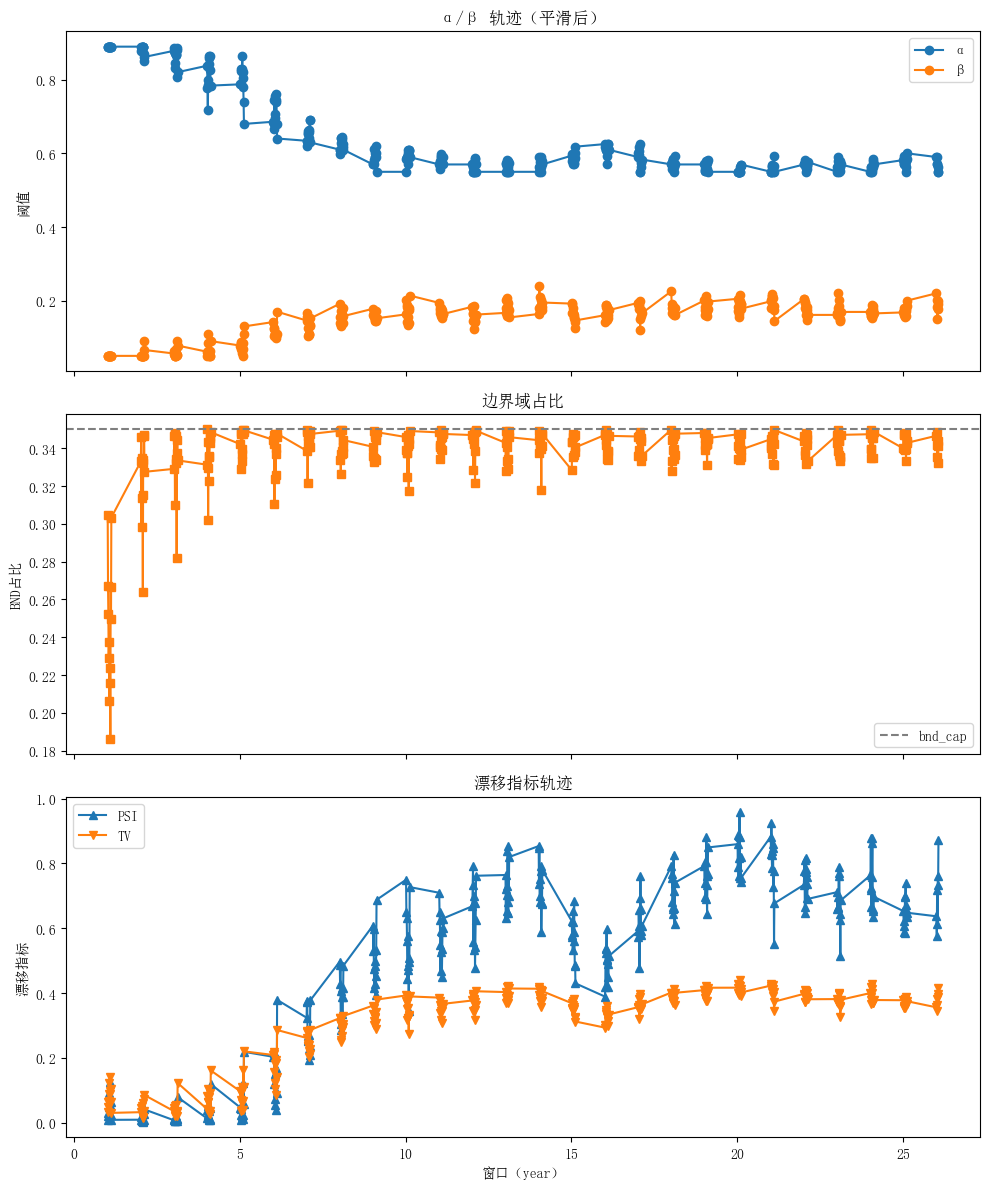

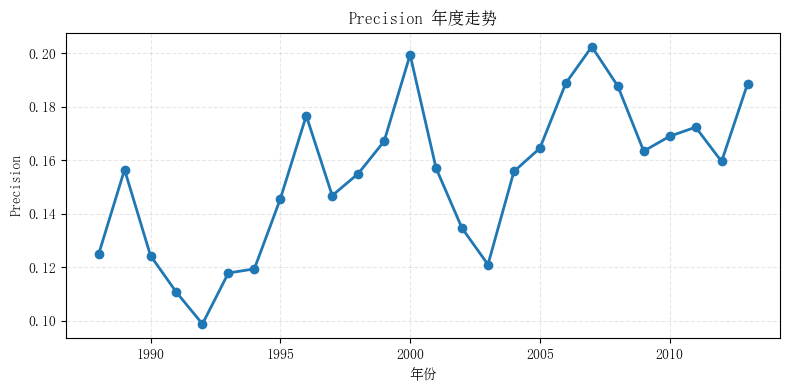

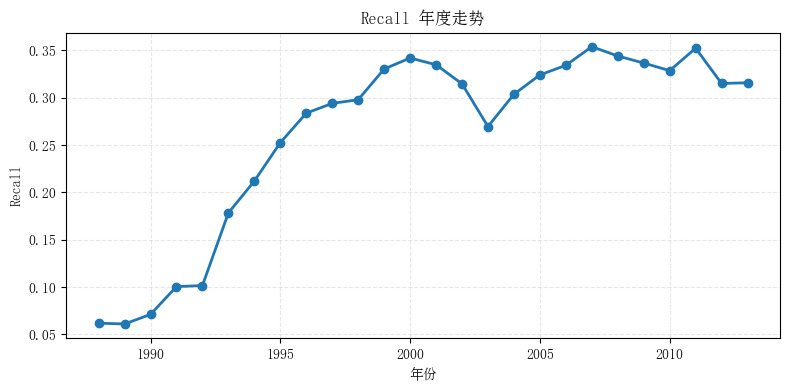

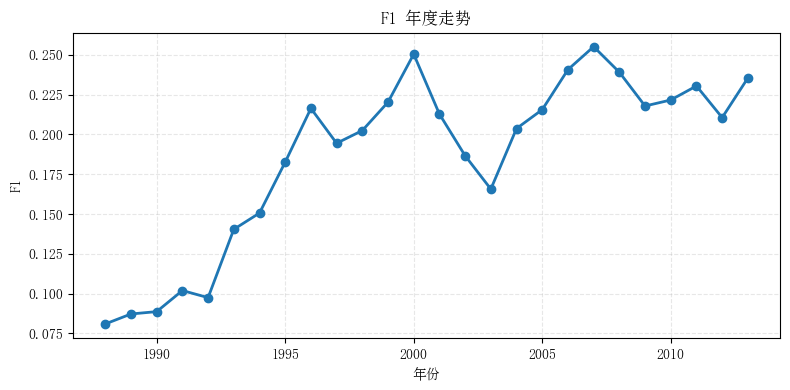

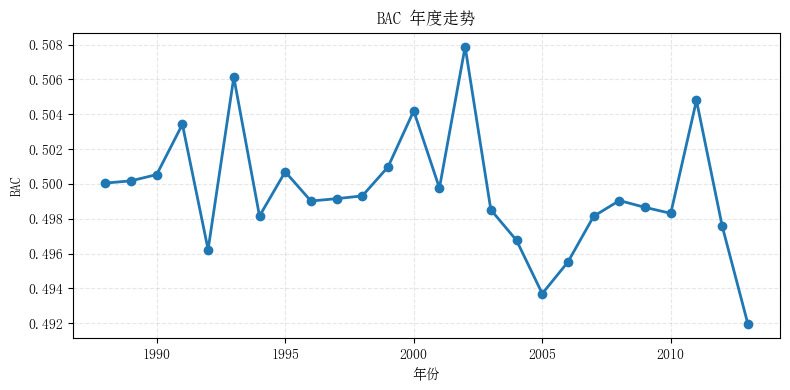

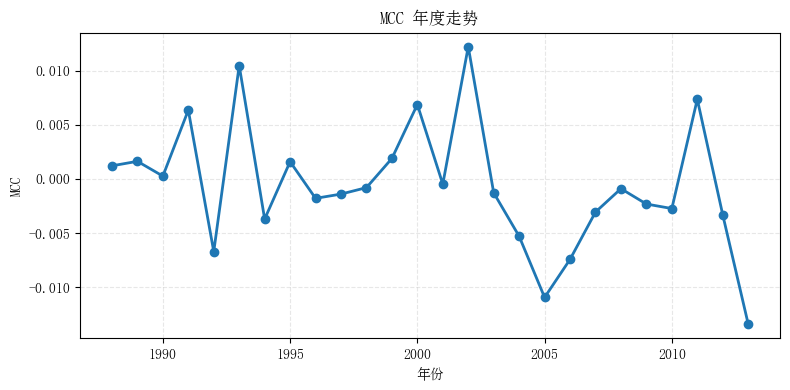

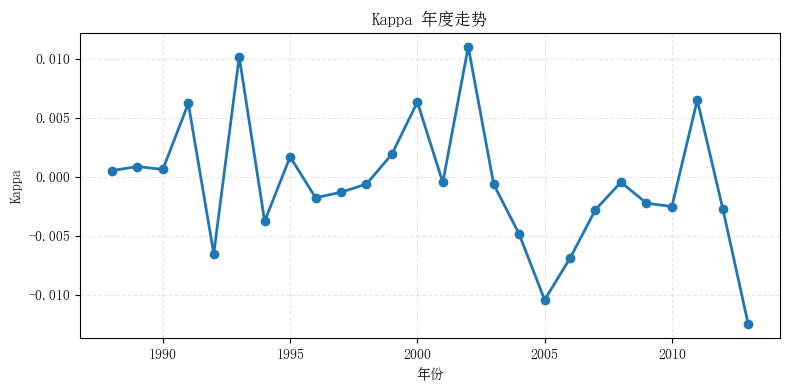

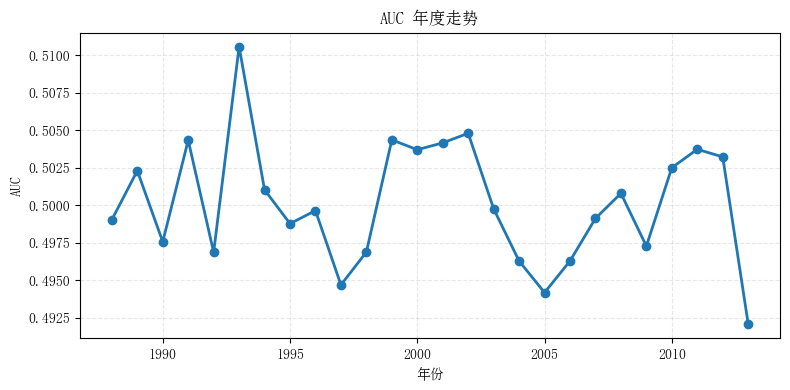

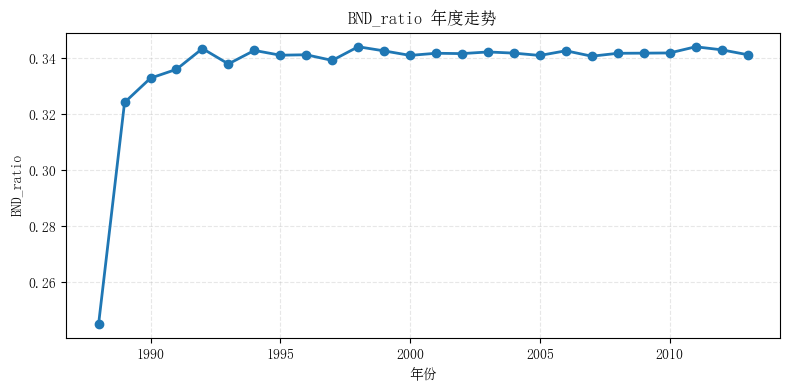

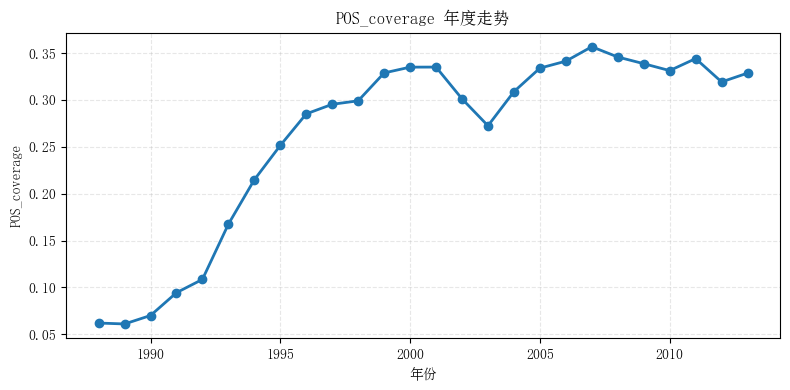

In [7]:
# 汇总阈值轨迹 / 漂移事件，并输出可视化与年度指标
trace_df = flow_threshold_df.copy() if 'flow_threshold_df' in globals() else pd.DataFrame(threshold_trace)
metrics_df = flow_metrics_df.copy() if 'flow_metrics_df' in globals() else pd.DataFrame(window_metrics)
drift_df = flow_drift_df.copy() if 'flow_drift_df' in globals() else pd.DataFrame(drift_events)
metrics_by_year_df = None
if 'yearly_metrics' in globals():
    metrics_by_year_df = yearly_metrics.copy()
elif 'metrics_by_year' in globals():
    metrics_by_year_df = metrics_by_year.copy()
else:
    metrics_by_year_df = pd.DataFrame()

output_dir = Path(cfg['DATA']['data_dir']).resolve()
output_dir.mkdir(parents=True, exist_ok=True)

trace_path = output_dir / 'threshold_trace_v02.csv'
metrics_path = output_dir / 'window_metrics.csv'
drift_path = output_dir / 'drift_events.csv'
year_metrics_path = output_dir / 'yearly_metrics.csv'

if not trace_df.empty:
    trace_df.to_csv(trace_path, index=False)
    print(f'【导出】阈值轨迹已保存到 {trace_path}')
if not metrics_df.empty:
    metrics_df.to_csv(metrics_path, index=False)
    print(f'【导出】窗口指标已保存到 {metrics_path}')
if not drift_df.empty:
    drift_df.to_csv(drift_path, index=False)
    print(f'【导出】漂移事件已保存到 {drift_path}')
if metrics_by_year_df is not None and not metrics_by_year_df.empty:
    if 'year' in metrics_by_year_df.columns:
        metrics_by_year_df = metrics_by_year_df.set_index('year')
    metrics_by_year_df.to_csv(year_metrics_path)
    print(f'【导出】年度指标已保存到 {year_metrics_path}')

if not trace_df.empty and not metrics_df.empty:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    axes[0].plot(trace_df['window'], trace_df['alpha_smoothed'], label='α', marker='o')
    axes[0].plot(trace_df['window'], trace_df['beta_smoothed'], label='β', marker='o')
    axes[0].set_ylabel('阈值')
    axes[0].set_title('α/β 轨迹（平滑后）')
    axes[0].legend()

    bnd_col = 'BND_ratio' if 'BND_ratio' in metrics_df.columns else ('bnd_ratio' if 'bnd_ratio' in metrics_df.columns else None)
    if bnd_col is not None:
        axes[1].plot(metrics_df['window'], metrics_df[bnd_col], color='tab:orange', marker='s')
    bnd_cap = cfg['MEASURE'].get('constraints', {}).get('bnd_cap')
    if bnd_cap is not None:
        axes[1].axhline(bnd_cap, color='tab:gray', linestyle='--', label='bnd_cap')
    axes[1].set_ylabel('BND占比')
    axes[1].set_title('边界域占比')
    axes[1].legend()

    axes[2].plot(metrics_df['window'], metrics_df['psi'], label='PSI', marker='^')
    axes[2].plot(metrics_df['window'], metrics_df['tv'], label='TV', marker='v')
    axes[2].set_ylabel('漂移指标')
    axes[2].set_xlabel('窗口（year）')
    axes[2].set_title('漂移指标轨迹')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
else:
    print('【提示】流式窗口为空，未生成阈值/漂移图表。')

if metrics_by_year_df is not None and not metrics_by_year_df.empty:
    years = metrics_by_year_df.index.astype(int)
    metric_titles = [
        ('Precision', 'Precision'),
        ('Recall', 'Recall'),
        ('F1', 'F1'),
        ('BAC', 'BAC'),
        ('MCC', 'MCC'),
        ('Kappa', 'Kappa'),
        ('AUC', 'AUC'),
        ('BND_ratio', 'BND_ratio'),
        ('POS_coverage', 'POS_coverage'),
    ]
    for column, title in metric_titles:
        if column not in metrics_by_year_df.columns:
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(years, metrics_by_year_df[column], marker='o', linewidth=2)
        ax.set_xlabel('年份')
        ax.set_ylabel(column)
        ax.set_title(f'{title} 年度走势')
        ax.grid(alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()
else:
    print('【提示】年度指标暂不可用。')
